In [1]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
import json
import mne
import numpy as np
from tqdm import tqdm
import re
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from multiprocessing import Pool
import warnings


os.chdir('../..')

# Load All The Experiments

In [2]:
def collect_valid_paths():
    root_dir = "Generated/Data"
    s_dir_pattern = re.compile(r"^S_\d+$")
    trial_dir_pattern = re.compile(r"^Trial_\d+$")
    valid_dirs = []
    for s_dir in os.listdir(root_dir):
        s_path = os.path.join(root_dir, s_dir)
        if os.path.isdir(s_path) and s_dir_pattern.match(s_dir):
            for trial_dir in os.listdir(s_path):
                trial_path = os.path.join(s_path, trial_dir)
                if os.path.isdir(trial_path) and trial_dir_pattern.match(trial_dir):
                    if any(os.path.isfile(os.path.join(trial_path, f)) for f in os.listdir(trial_path)):
                        valid_dirs.append(trial_path)
    return valid_dirs

all_paths = collect_valid_paths()

print(f"Найдено {len(all_paths)} подходящих директорий")

Найдено 27 подходящих директорий


In [3]:
def load_eeg(path):
    eeg_clean_path = os.path.join(path, "EEG_clean.fif")
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning, module="mne")
        clean_eeg = mne.io.read_raw_fif(eeg_clean_path, preload=True, verbose=False)
    
    clean_eeg.pick_types(eeg=True, verbose=False)

    # Извлечем S_13 и Trial_2 из пути
    parts = path.strip(os.sep).split(os.sep)
    subj = parts[-2]
    trial = parts[-1]

    subj_id = int(subj.split('_')[-1])
    trial_id = int(trial.split('_')[-1])

    
    key = f"S{subj_id}_T{trial_id}"

    # !!!TODO!!! сюда добавить данные испытуемых с таблицы.
    return key, [clean_eeg, subj_id, trial_id]
        

# Параллельная загрузка
with Pool(processes=72)  as pool:
    results = list(tqdm(pool.imap(load_eeg, all_paths), total=len(all_paths)))

# Собрать словарь, исключив ошибки
data_tuple = {k: v for k, v in results if k is not None}

eeg, subj, trial = data_tuple['S6_T1']

100%|██████████| 27/27 [01:51<00:00,  4.14s/it]


### Get the subjects info

In [5]:
from datetime import datetime

# --- 1) Читаем Excel, пропуская первую строку «слитного» заголовка ---
file_path = './Supplementary/Experiment_Metadata.xlsx'
df_raw = pd.read_excel(file_path, header=1)

# --- 2) Переименовываем нужные колонки ---
df_raw = df_raw.rename(columns={
    'Subject ID'         : 'Subject_id',
    'Имя'                : 'Name',
    'Фамилия'            : 'Surname',
    'Дата Рождения'      : 'Birthdate',
    'Пол'                : 'Gender',
    'Правша / Левша'     : 'Handiness',
})

# --- 3) Оставляем только нужные поля, включая Handiness ---
df = df_raw[['Subject_id', 'Name', 'Surname', 'Birthdate', 'Gender', 'Handiness']].copy()

# --- 4) Преобразуем «Пол» из кириллицы в латинскую букву m/f ---
gender_map = {'М': 'm', 'Ж': 'f'}
df['Gender'] = df['Gender'].map(gender_map)

# --- 5) Преобразуем «Handiness» в r/l ---
# Предполагаем, что в файле пишется именно «Правша» или «Левша»
hand_map = {'Правша': 'r', 'Левша': 'l'}
df['Handiness'] = df['Handiness'].map(hand_map)

# --- 6) Переводим «Дата Рождения» в datetime ---
df['Birthdate'] = pd.to_datetime(df['Birthdate'], dayfirst=True, errors='coerce')

# --- 7) Считаем возраст в годах (целое число) ---
today = datetime.today()
def calculate_age(birth_dt):
    if pd.isna(birth_dt):
        return None
    years = today.year - birth_dt.year
    if (today.month, today.day) < (birth_dt.month, birth_dt.day):
        years -= 1
    return int(years)

df['Age'] = df['Birthdate'].apply(calculate_age)

# --- 8) Заменяем NaN в Age на 0, превращая колонку в целочисленную ---
df['Age'] = df['Age'].fillna(0).astype(int)

# --- 9) Удаляем колонку Birthdate, она больше не нужна ---
df = df.drop(columns=['Birthdate'])

# --- 10) Делаем Subject_id индексом ---
subject_metadata = df.set_index('Subject_id')

subject_metadata

,Name,Surname,Gender,Handiness,Age
Subject_id,,,,,
1,Софья,Гамершмидт,f,r,21
2,Сергей,Пешков,m,r,19
3,Рувшан,Давлитшин,m,r,18
4,Мухаббат,Давлатова,f,r,30
5,Камиль,Фоатов,m,r,0
6,Алия,Хадеева,f,r,18
7,Алёна,Петренко,f,r,19
8,Умар,Магомедов,m,r,18
9,Мария,Мельникова,f,r,31


# Compute Morlet Spectras (PSD)

As a result, produces:
* `psds_array` - list of psds morlet wavelet spectras
* `metadata`   - list of [`sub_id`, `trial_id`, `gender`, `handiness`, `age`, ...] 

In [7]:
from mne.time_frequency import tfr_array_morlet

n_jobs = 40

results_arr = []
for key, (eeg, subj, trial) in tqdm(data_tuple.items()):
    # Получаем данные (n_channels, n_times)
    data = eeg.get_data()
    
    # Параметры Морле
    freqs = np.linspace(2, 40, 40*2)  # Частоты от 2 до 40 Гц
    n_cycles = freqs / 2.0          # Больше циклов — выше частотная точность
    
    # Преобразуем в (n_epochs=1, n_channels, n_times)
    data_reshaped = data[np.newaxis, :, :]
    
    # Морле преобразование (получим мощность)
    power = tfr_array_morlet(
        data_reshaped,
        sfreq=eeg.info['sfreq'],
        freqs=freqs,
        n_cycles=n_cycles,
        output='power',
        decim=10,          # ускорим вычисления (10x уменьшение)
        n_jobs=n_jobs,
        verbose = False
    )  # Результат: (1, n_channels, n_freqs, n_times)
    
    # Усредняем по времени
    power_mean = power.mean(axis=-1)[0]  # (n_channels, n_freqs)

    gender    = subject_metadata.loc[subj, 'Gender']
    handiness = subject_metadata.loc[subj, 'Handiness']
    age       = subject_metadata.loc[subj, 'Age']
    
    results_arr.append([power_mean, subj, trial, gender, handiness, age])

results_arr[0][0].shape

100%|██████████| 27/27 [1:20:32<00:00, 179.00s/it]


(63, 80)

In [9]:
save_dict = {}
for i, entry in enumerate(results_arr):
    psd, s_id, t_id, gender, handiness, age = entry
    save_dict[f'morlet_psd_{i}'] = psd
    save_dict[f'subject_id_{i}'] = np.array(s_id)
    save_dict[f'trial_id_{i}'] = np.array(t_id)
    save_dict[f'gender_{i}'] = np.array(gender, dtype='U1')
    save_dict[f'handiness_{i}']  = np.array(handiness, dtype='U1')
    save_dict[f'age_{i}'] = np.array(age, dtype=int)

# Сохраняем в .npz
np.savez('psds_array.npz', **save_dict)

### load the morlet psds if you dont want to compute ones

In [10]:
loaded = np.load('psds_array.npz')

results_arr = []

i = 0
while f'morlet_psd_{i}' in loaded:
    psd = loaded[f'morlet_psd_{i}']
    s_id = int(loaded[f'subject_id_{i}'])
    t_id = int(loaded[f'trial_id_{i}'])
    gender = str(loaded[f'gender_{i}'])
    handiness = str(loaded[f'handiness_{i}'])
    age = int(loaded[f'age_{i}'])
    
    results_arr.append([psd, s_id, t_id, gender, handiness, age])
    i += 1

psd, s_id, t_id, gender, handiness, age = results_arr[0]
psd.shape

(63, 80)

In [11]:
# Parse into two lists will be used furthere
psds_array = [item[0] for item in results_arr]
psds_array = np.array(psds_array)                            # Convert list of PSDs to a numpy array
psds_array = psds_array.reshape((psds_array.shape[0], -1))   # Vectorize 

metadata = [item[1:] for item in results_arr]

psds_array.shape

(27, 5040)

# NFT

In [119]:
from tensorly.decomposition import non_negative_parafac
import tensorly as tl

# Восстановим тензорную форму (27, 63, 80)
tensor = psds_array.reshape(27, 63, 80)
tl.set_backend('numpy')

# Понижаем размерность через NTF с rank=3
rank = 30
weights, factors = non_negative_parafac(tensor, rank=rank, return_errors=False)

# factors = (A, B, C)
A = factors[0]  # By subjects (27, rank)
B = factors[1]  # By channels (63, rank)
C = factors[2]  # By freqs (40*2, rank)

reduced_data = A # because it contains by subjects

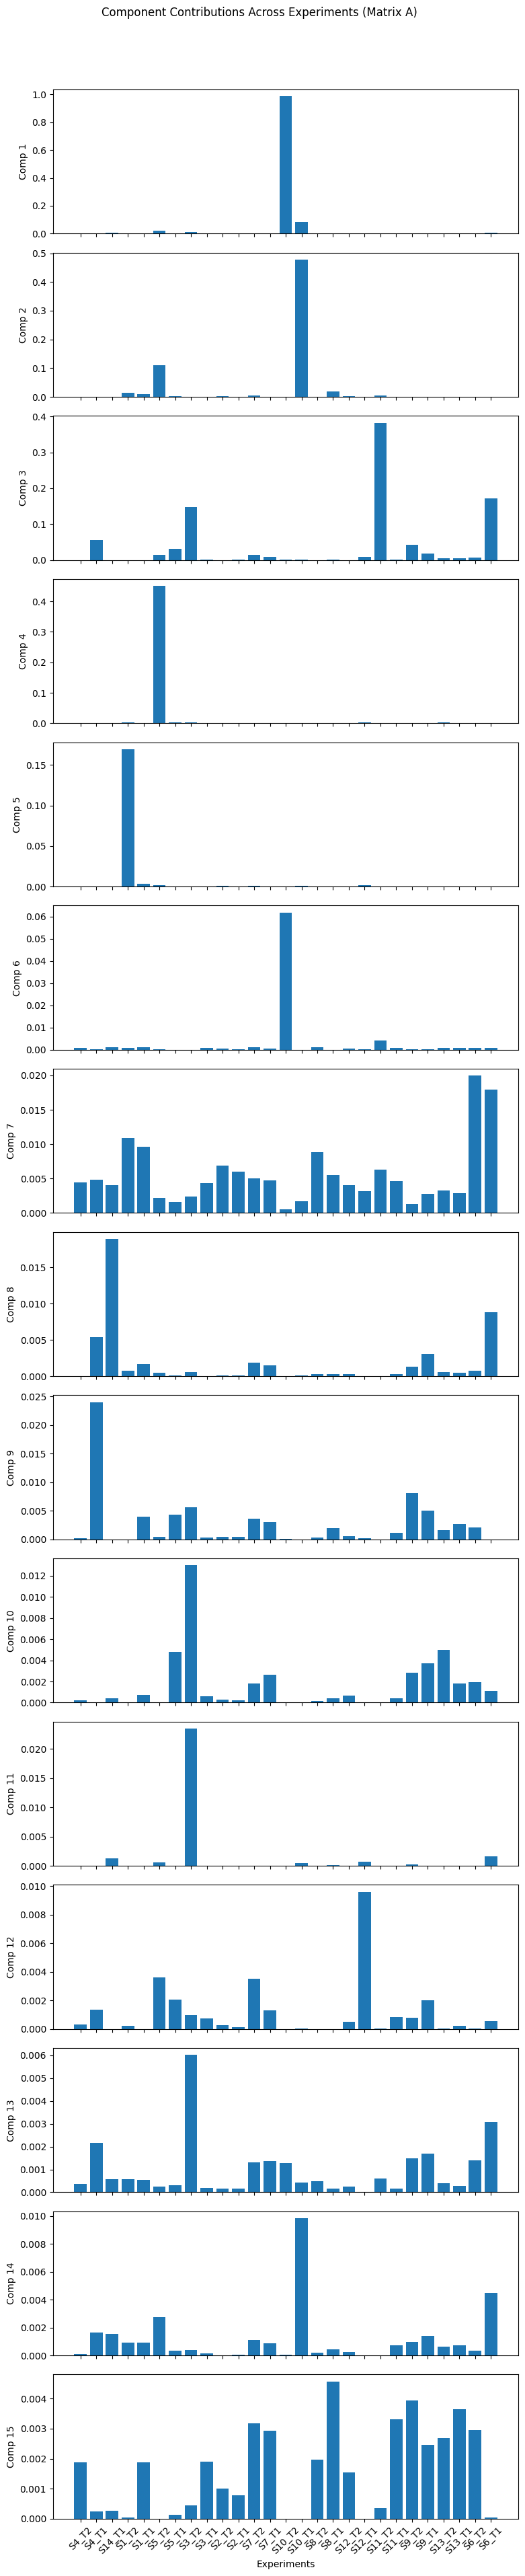

In [71]:
n_components = A.shape[1]
fig, axes = plt.subplots(n_components, 1, figsize=(8, 2.5 * n_components), sharex=True)

for r in range(n_components):
    axes[r].bar(range(1, A.shape[0]+1), A[:, r])
    axes[r].set_ylabel(f'Comp {r+1}')
    axes[r].set_xticks(range(1, A.shape[0]+1))
    axes[r].set_xticklabels([f'S{meta[0]}_T{meta[1]}' for meta in metadata], rotation=45)

    
    subject_ids = [meta[0] for meta in metadata]
trial_ids = [meta[1] for meta in metadata]
axes[-1].set_xlabel('Experiments')
plt.suptitle('Component Contributions Across Experiments (Matrix A)', y=1.02)
plt.tight_layout()
plt.show()

1


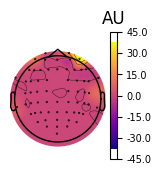

2


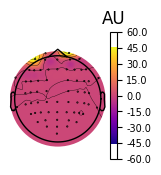

3


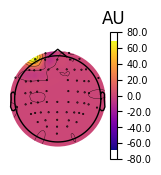

4


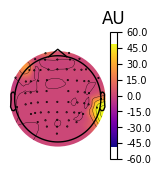

5


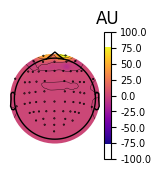

6


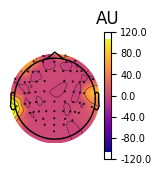

7


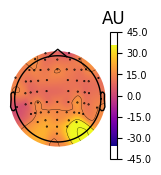

8


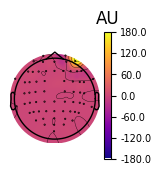

9


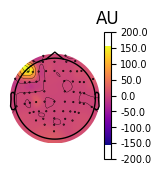

10


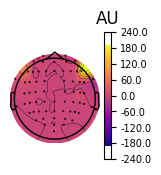

11


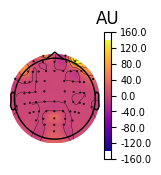

12


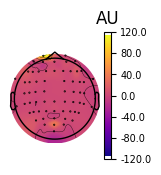

13


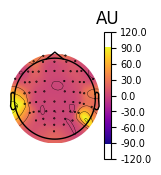

14


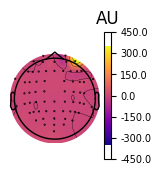

15


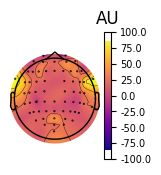

In [72]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# Получаем названия каналов из существующего объекта eeg
ch_names = eeg.info['ch_names']

# Используем соответствующий монтаж (если каналы соответствуют стандартной схеме 10-20)
montage = mne.channels.make_standard_montage('standard_1020')

# Создаём Info объект для визуализации
info = mne.create_info(ch_names=ch_names, sfreq=1000, ch_types='eeg')
info.set_montage(montage)

# Визуализация компонентов
for k in range(rank):
    print(k+1)
    topo_data = B[:, k]  # B — матрица топографий (63 канала × кол-во компонентов)
    
    # Создаём объект EvokedArray
    evoked = mne.EvokedArray(topo_data[:, np.newaxis], info, tmin=0)
    
    # Строим топоплот с подписью K
    evoked.plot_topomap(
        times=0, 
        scalings=1, 
        time_format='', 
        cmap='plasma'
    )

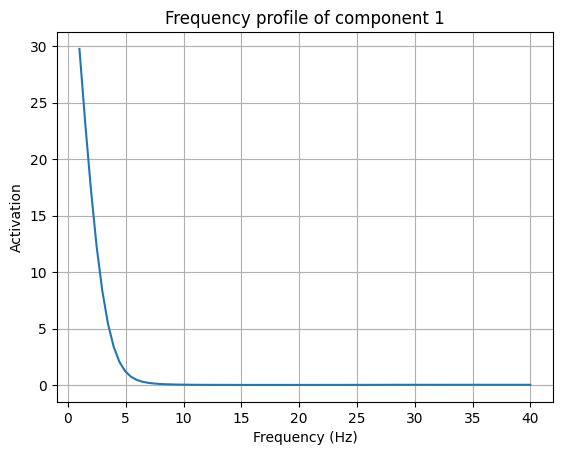

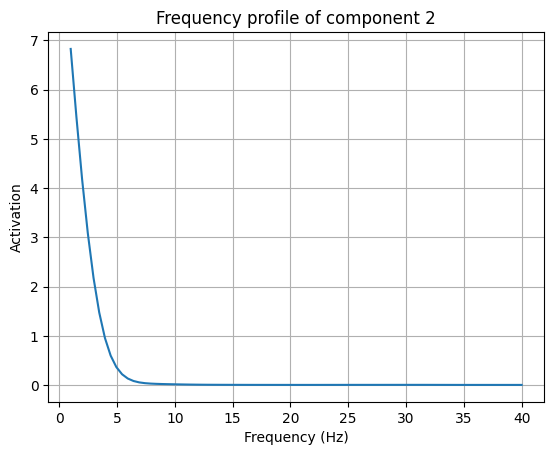

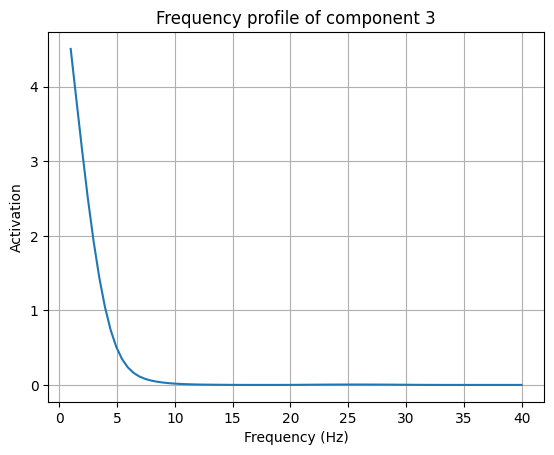

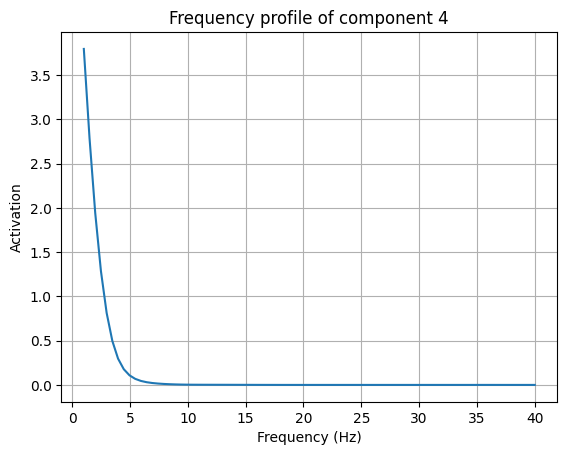

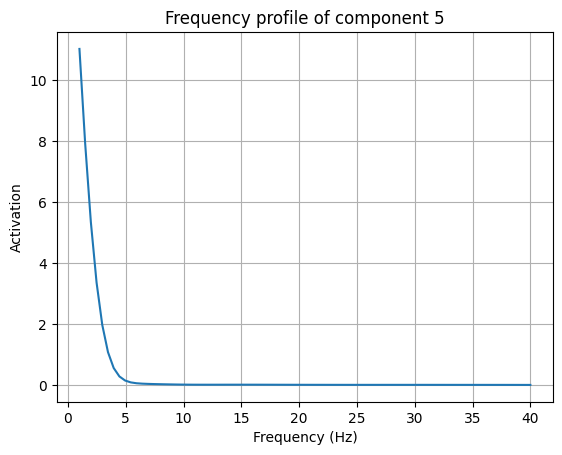

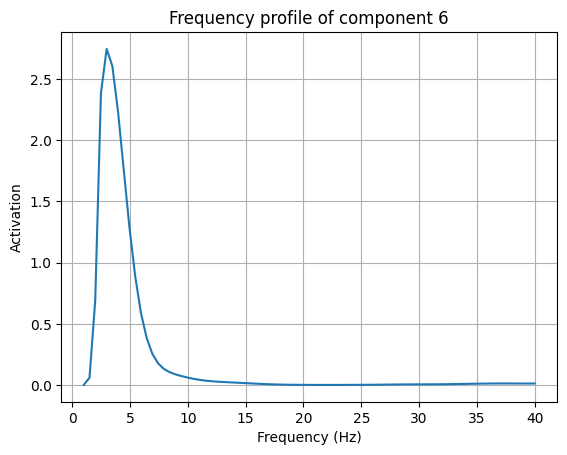

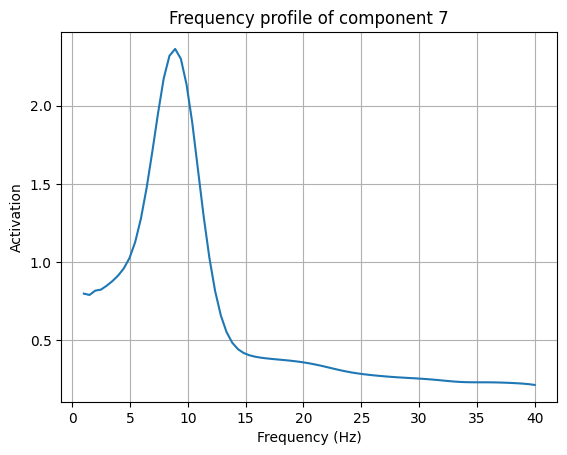

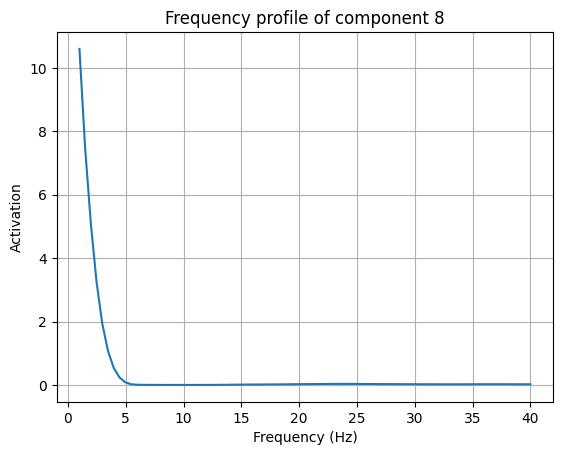

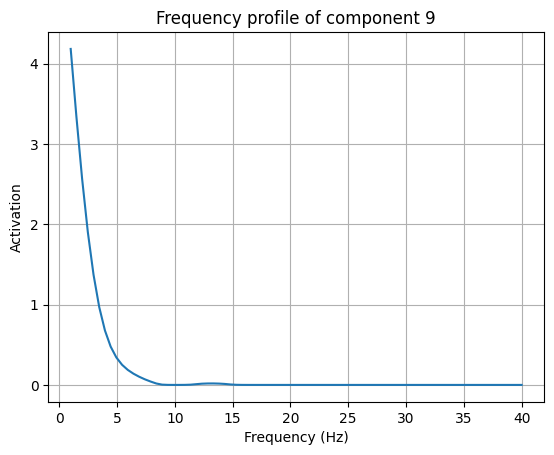

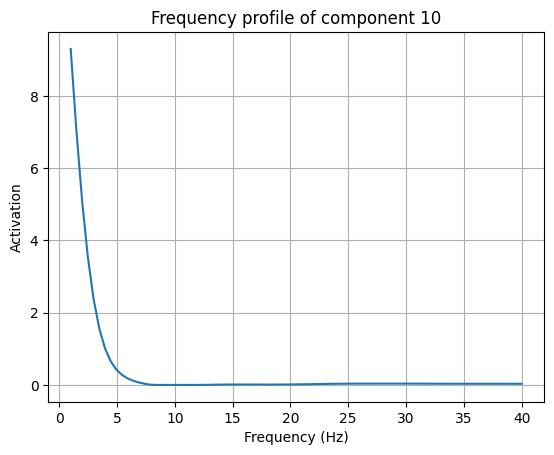

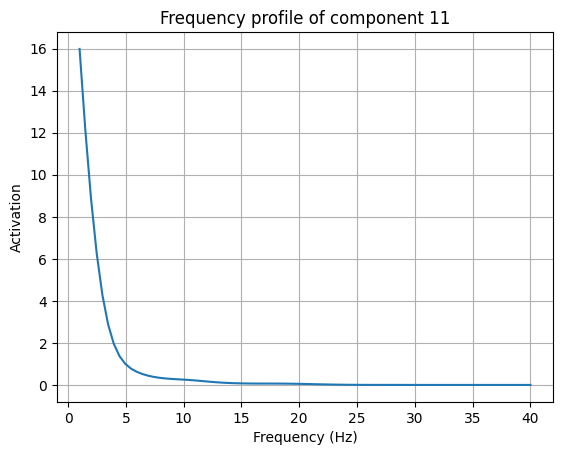

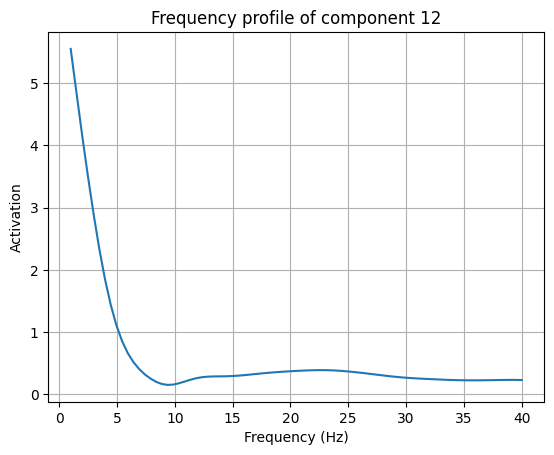

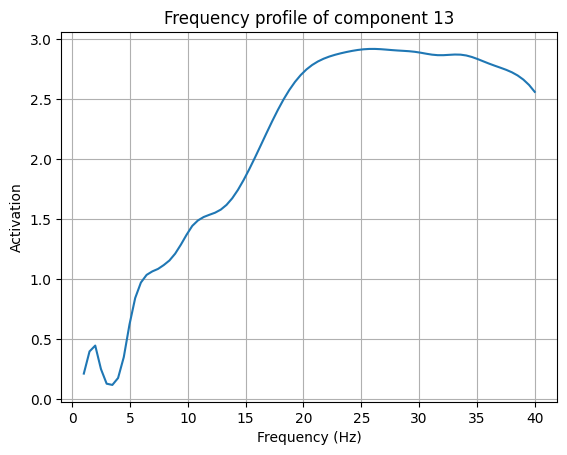

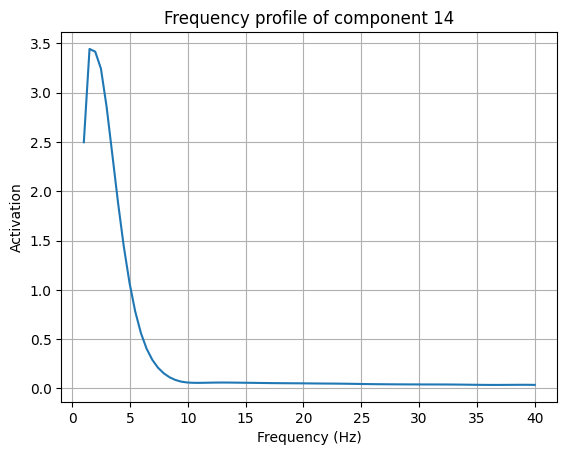

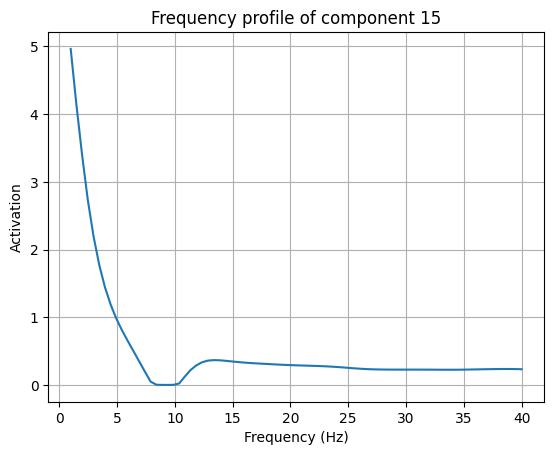

In [73]:
for k in range(rank):

    freqs = np.linspace(1, 40, 40*2)  # или точные морлет-частоты
    plt.figure()
    plt.plot(freqs, C[:, k])
    plt.title(f'Frequency profile of component {k+1}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Activation')
    plt.grid()
    plt.show()